In [1]:
! pip install opencv-python
import numpy as np
import random
import torch
import os
from torchvision import transforms
import scipy.io
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from transformers import ViTModel
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(device).total_memory
    util_memory = torch.cuda.memory_reserved(device)
    total_memory = total_memory / (1024 ** 2)
    util_memory = util_memory / (1024 ** 2)
    
    print(f"Total GPU memory: {total_memory:.2f} MB")
    print(f"Utilized GPU memory: {util_memory:.2f} MB")
else:
    print("CUDA is not available on this machine.")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)


/home/lemaire238/Documents/parsingData/diaparser/diaparser_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Total GPU memory: 11904.31 MB
Utilized GPU memory: 0.00 MB


# Modele NN

In [2]:

class ImageEncoder(nn.Module):
    def __init__(self, pretrained_vit):
        super().__init__()
        self.vit = pretrained_vit

    def forward(self, x):
        outputs = self.vit(x, output_hidden_states=True, interpolate_pos_encoding=True)
        hidden_states = outputs.hidden_states
        intermediate_features = [hidden_states[i][:, 1:, :] for i in [3, 6, 9, 12]] 
        return intermediate_features 
    
    
class ConvBnReluBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.33):
        super(ConvBnReluBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        #self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        x = self.relu(x)
        #x = self.dropout(x)
        return x

class DeconvConvBnReluBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, dropout_prob=0.33):
        super(DeconvConvBnReluBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        x = self.deconv(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        #x = self.dropout(x)
        return x

class SaliencyDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconv_z12 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        
        self.deconvconv_z9  = DeconvConvBnReluBlock(in_channels=768, mid_channels=576, out_channels=384)
        
        self.conv1_z9z12 = ConvBnReluBlock(768, out_channels=576)
        self.conv2_z9z12 = ConvBnReluBlock(in_channels=576, out_channels=384)
        self.deconv_z9z12 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)

        self.deconvconv1_z6  = DeconvConvBnReluBlock(in_channels=768, mid_channels=624, out_channels=480)
        self.deconvconv2_z6  = DeconvConvBnReluBlock(in_channels=480, mid_channels=336, out_channels=192)

        self.conv1_z6z12z9 = ConvBnReluBlock(in_channels=384, out_channels=288)
        self.conv2_z6z12z9 = ConvBnReluBlock(in_channels=288, out_channels=192)
        self.deconv_z6z12z9 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)

        self.deconvconv1_z3  = DeconvConvBnReluBlock(in_channels=768, mid_channels=672, out_channels=576)
        self.deconvconv2_z3  = DeconvConvBnReluBlock(in_channels=576, mid_channels = 432, out_channels=288)
        self.deconvconv3_z3  = DeconvConvBnReluBlock(in_channels=288, mid_channels=192, out_channels=96)

        self.conv1_z3z6z12z9 = ConvBnReluBlock(in_channels=192, out_channels=144)
        self.conv2_z3z6z12z9 = ConvBnReluBlock(in_channels=144, out_channels=96)
        self.deconv_z3z6z12z9 = nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2)

        self.conv1_x = ConvBnReluBlock(in_channels=3, out_channels=12)
        self.conv2_x = ConvBnReluBlock(in_channels=12, out_channels=48)

        self.conv1_last = ConvBnReluBlock(in_channels=96, out_channels=32)
        self.conv2_last = ConvBnReluBlock(32, 8)

        self.conv1x1 = nn.Conv2d(8, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, intermediate_features):
        batch_size, _, height, width = x.size()
        patch_grid_size_h = height // 16
        patch_grid_size_w = width // 16 
        
        z3, z6, z9, z12 = intermediate_features
        z3 = z3.permute(0, 2, 1).view(z3.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z6 = z6.permute(0, 2, 1).view(z6.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z9 = z9.permute(0, 2, 1).view(z9.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z12 = z12.permute(0, 2, 1).view(z12.size(0), 768, patch_grid_size_h, patch_grid_size_w)

        z12 = self.deconv_z12(z12)
        z9 = self.deconvconv_z9(z9)
        z12_9 = torch.cat((z9,z12),1)
        z12_9 = self.deconv_z9z12(self.conv2_z9z12(self.conv1_z9z12(z12_9)))
        z6  = self.deconvconv2_z6(self.deconvconv1_z6(z6))
        z6_12_9 = torch.cat((z6,z12_9),1)
        z6_12_9 = self.deconv_z6z12z9(self.conv2_z6z12z9(self.conv1_z6z12z9(z6_12_9)))
        z3 = self.deconvconv3_z3(self.deconvconv2_z3(self.deconvconv1_z3(z3)))
        z3_6_12_9 = torch.cat((z3,z6_12_9),1)
        z3_6_12_9 = self.deconv_z3z6z12z9(self.conv2_z3z6z12z9(self.conv1_z3z6z12z9(z3_6_12_9)))
        
        x = self.conv2_x(self.conv1_x(x))

        last = torch.cat((x,z3_6_12_9),1)
        saliency_map = self.conv1x1(self.conv2_last(self.conv1_last(last)))
        saliency_map = self.sigmoid(saliency_map)

        return saliency_map




class ImageSaliencyModel(nn.Module):
    def __init__(self, image_vit):
        super().__init__()
        self.image_encoder = ImageEncoder(image_vit)
        self.saliency_decoder = SaliencyDecoder()

    def forward(self, images):
        intermediate_features = self.image_encoder(images)
        img_predicted_saliency = self.saliency_decoder(x = images, intermediate_features=intermediate_features)
        return img_predicted_saliency


In [3]:
from transformers import ViTModel

image_vit = ViTModel.from_pretrained('google/vit-base-patch16-384')

model = ImageSaliencyModel(image_vit)
checkpoint = torch.load('eval_direct_origsize_bs16.pth', map_location=torch.device('cpu'))

new_checkpoint = {}
for k, v in checkpoint.items():
    new_key = k.replace("module.", "")
    new_checkpoint[new_key] = v

model.load_state_dict(new_checkpoint)
#model = nn.DataParallel(model)
model = model.to(device)
model.eval()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageSaliencyModel(
  (image_encoder): ImageEncoder(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Lin

In [4]:
class ImageSaliencyDataset(Dataset):
    def __init__(self, image_paths, image_transforms=None):
        self.image_paths = image_paths
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = self.image_paths[idx].split('/')[-1]
        #folder_name = self.image_paths[idx].split('/')[-2]
        image = Image.open(image_path).convert("RGB")
        orig_size = image.size

        if self.image_transforms:
            image = self.image_transforms(image)

        return image, image_name, orig_size


train_transforms_img = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_folder_imgs = 'paintings_all'
train_imgs = [os.path.join(train_folder_imgs, img) for img in sorted(os.listdir(train_folder_imgs)) if img.endswith('.jpg')][:]
batch_size = 1
MIT_dataset = ImageSaliencyDataset(train_imgs, train_transforms_img)
test_dataloader = DataLoader(MIT_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"set size: {len(MIT_dataset)}")


def save_model_outputs_as_png(output, output_dir, filename, orig_size):
    """
    Save model outputs as PNG images.

    Parameters:
    - outputs: Tensor of shape (batch_size, 1, H, W) or (batch_size, H, W).
    - output_dir: Directory to save the images.
    - base_filename: Base filename for the images.
    """
    if output.dim() == 4:
        output = output.squeeze(1)

    to_pil = transforms.ToPILImage()
    output = (output * 255).byte()
    img = to_pil(output.cpu())
    img = img.resize(orig_size, Image.BILINEAR)

    img.save(os.path.join(output_dir, f"{filename[0]}"))

set size: 11


In [5]:
for img in MIT_dataset:
    print(img[0].size(), img[2])
image_t = MIT_dataset[0][0]


torch.Size([3, 480, 640]) (1170, 784)
torch.Size([3, 480, 640]) (1200, 883)
torch.Size([3, 480, 640]) (772, 1200)
torch.Size([3, 480, 640]) (1170, 1479)
torch.Size([3, 480, 640]) (890, 1200)
torch.Size([3, 480, 640]) (1200, 897)
torch.Size([3, 480, 640]) (1170, 917)
torch.Size([3, 480, 640]) (3828, 3227)
torch.Size([3, 480, 640]) (3911, 3071)
torch.Size([3, 480, 640]) (1170, 1456)
torch.Size([3, 480, 640]) (898, 1200)


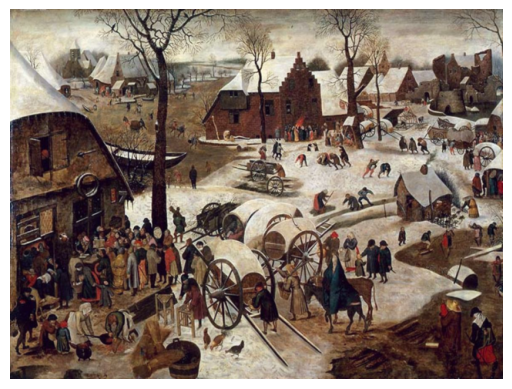

In [6]:
import matplotlib.pyplot as plt
tensor = image_t  
if tensor.is_cuda:
    tensor = tensor.cpu()
image = tensor.numpy()
if image.min() < 0 or image.max() > 1:
    image = (image - image.min()) / (image.max() - image.min())
image = image.transpose(1, 2, 0)

plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
output_directory = 'paintings_saliency_cat'
os.makedirs(output_directory, exist_ok=True)
for images,image_names, orig_sizes in test_dataloader:
    images= images.to(device)
    with torch.no_grad():
        predicted_saliency = model.forward(images)
        save_model_outputs_as_png(predicted_saliency, output_directory, image_names, orig_sizes)
print('Finished')

Finished


# Creating a deformed image


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/lemaire238/Documents/parsingData/diaparser/diaparser_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


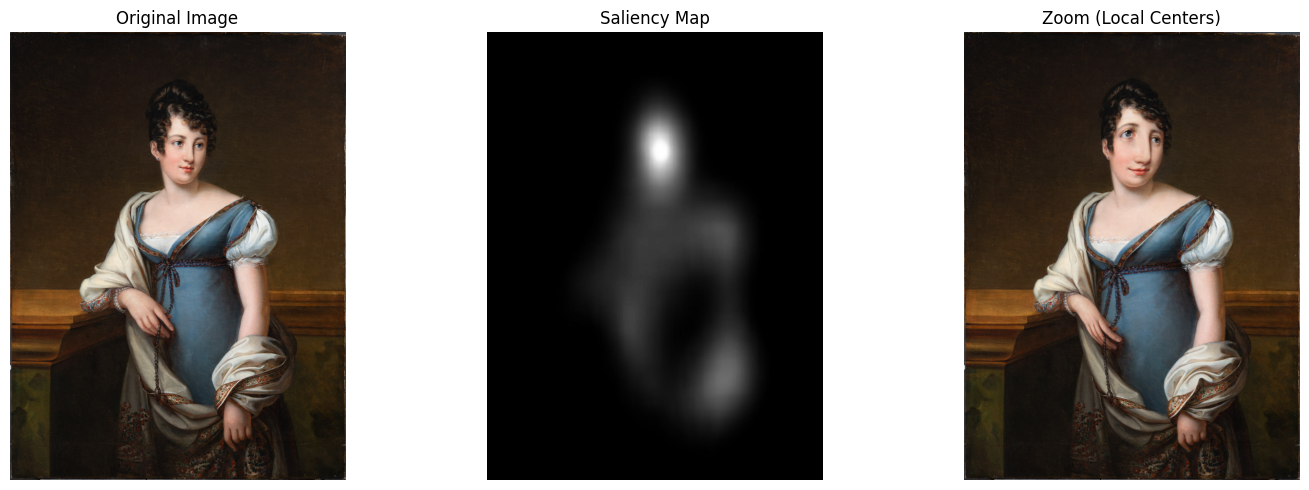

In [9]:
%pip install opencv-python
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates, maximum_filter
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

class SaliencyDeformer:
    def __init__(self, image, saliency_map):
        """
        Initialize the deformer with an image and its saliency map.
        
        Args:
            image: RGB image (H, W, 3) with values in [0, 255] or [0, 1]
            saliency_map: Grayscale saliency map (H, W) with values in [0, 1]
        """
        if image.max() > 1:
            self.image = image.astype(np.float32) / 255.0
        else:
            self.image = image.astype(np.float32)
            
        self.saliency = np.clip(saliency_map.astype(np.float32), 0, 1)
        
        if self.saliency.shape != self.image.shape[:2]:
            self.saliency = cv2.resize(self.saliency, 
                                    (self.image.shape[1], self.image.shape[0]),
                                    interpolation=cv2.INTER_LINEAR)
        
        self.height, self.width = self.image.shape[:2]
    
    def _interpolate_image(self, new_y, new_x):
        """
        Interpolate the image using the new coordinate mappings.
        """
        new_y = np.clip(new_y, 0, self.height - 1)
        new_x = np.clip(new_x, 0, self.width - 1)
        
        if len(self.image.shape) == 3:
            deformed = np.zeros_like(self.image)
            for c in range(self.image.shape[2]):
                deformed[:, :, c] = map_coordinates(
                    self.image[:, :, c], 
                    [new_y, new_x], 
                    order=1, 
                    mode='reflect'
                )
        else:
            deformed = map_coordinates(
                self.image, 
                [new_y, new_x], 
                order=1, 
                mode='reflect'
            )
        
        return np.clip(deformed, 0, 1)
    
    def _find_local_saliency_centers(self, blur_sigma):
        """
        Find local centers of high saliency for each pixel.
        This creates a field where each pixel points to its nearest high-saliency center.
        """
        smoothed_saliency = gaussian_filter(self.saliency, sigma=blur_sigma)
        
        local_maxima = maximum_filter(smoothed_saliency, size=int(blur_sigma * 2)) == smoothed_saliency
        local_maxima = local_maxima & (smoothed_saliency > 0.3)  
        
        max_coords = np.where(local_maxima)
        max_y = max_coords[0]
        max_x = max_coords[1]
        max_values = smoothed_saliency[max_y, max_x]
        
        if len(max_y) == 0:
            center_y = np.full((self.height, self.width), self.height // 2, dtype=np.float32)
            center_x = np.full((self.height, self.width), self.width // 2, dtype=np.float32)
            return center_y, center_x
        
        y_grid, x_grid = np.mgrid[0:self.height, 0:self.width]
        
        center_y = np.zeros((self.height, self.width), dtype=np.float32)
        center_x = np.zeros((self.height, self.width), dtype=np.float32)
        
        for i in range(self.height):
            for j in range(self.width):
                distances = np.sqrt((max_y - i)**2 + (max_x - j)**2)
                
                weights = max_values / (distances + 1e-6)
                weights = weights / np.sum(weights)
                
                center_y[i, j] = np.sum(weights * max_y)
                center_x[i, j] = np.sum(weights * max_x)
        
        return center_y, center_x
    
    def zoom_deformation(self, zoom_strength=0.5, blur_sigma=5, local_centers=True):
        """
        Apply zoom effect to salient regions - expands high-saliency areas.
        
        Args:
            zoom_strength: How strong the zoom effect is (0.1 to 2.0)
            blur_sigma: Gaussian blur for smoothing the deformation field
            local_centers: If True, zoom around local saliency centers; if False, use global center
        """
        zoom_field = gaussian_filter(self.saliency, sigma=blur_sigma)
        zoom_field = zoom_field * zoom_strength + 1.0  # Base zoom of 1.0
                y, x = np.mgrid[0:self.height, 0:self.width]
        
        if local_centers:
            center_y, center_x = self._find_local_saliency_centers(blur_sigma * 2)
        else:
            center_y = np.full_like(y, self.height // 2, dtype=np.float32)
            center_x = np.full_like(x, self.width // 2, dtype=np.float32)
        dy = y - center_y
        dx = x - center_x
        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field
        deformed = self._interpolate_image(new_y, new_x)
        return deformed
    
    


def demonstrate_effects(img_path, sal_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0
    deformer = SaliencyDeformer(image, saliency)
    zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(saliency, cmap='gray')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')
    
    axes[2].imshow(zoom_result)
    axes[2].set_title('Zoom (Local Centers)')
    axes[2].axis('off')
    #verlay_saliency_on_image
    plt.tight_layout()
    plt.show()



img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_salicon/{img_name}'

demonstrate_effects(img_path, sal_path)

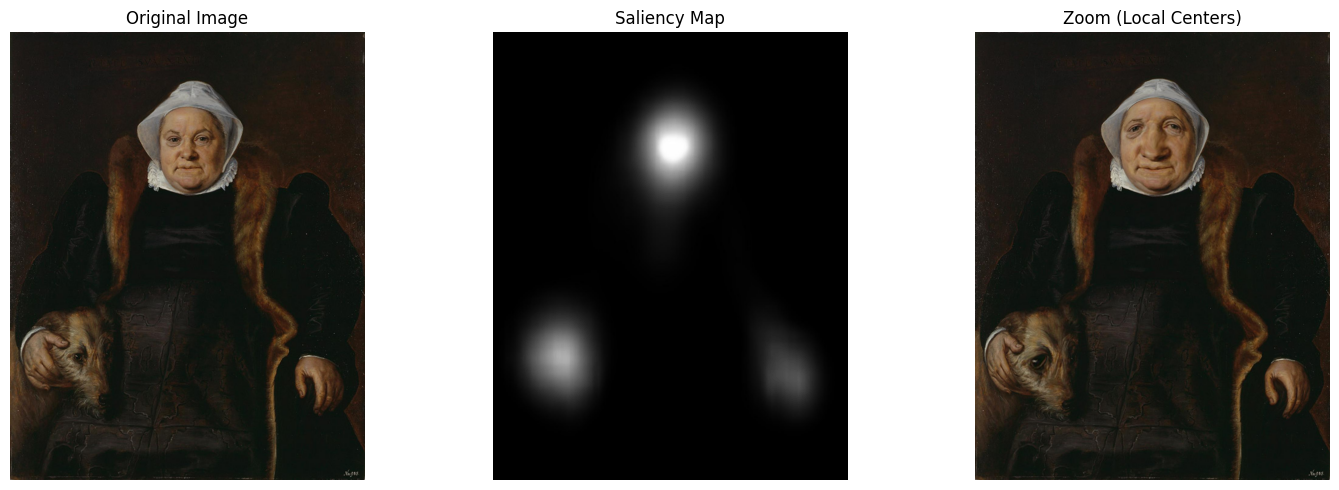

In [10]:
img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'
img_name  = 'FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_cat/{img_name}'

demonstrate_effects(img_path, sal_path)

## Code ajouté pour la vidéo de 3 minutes


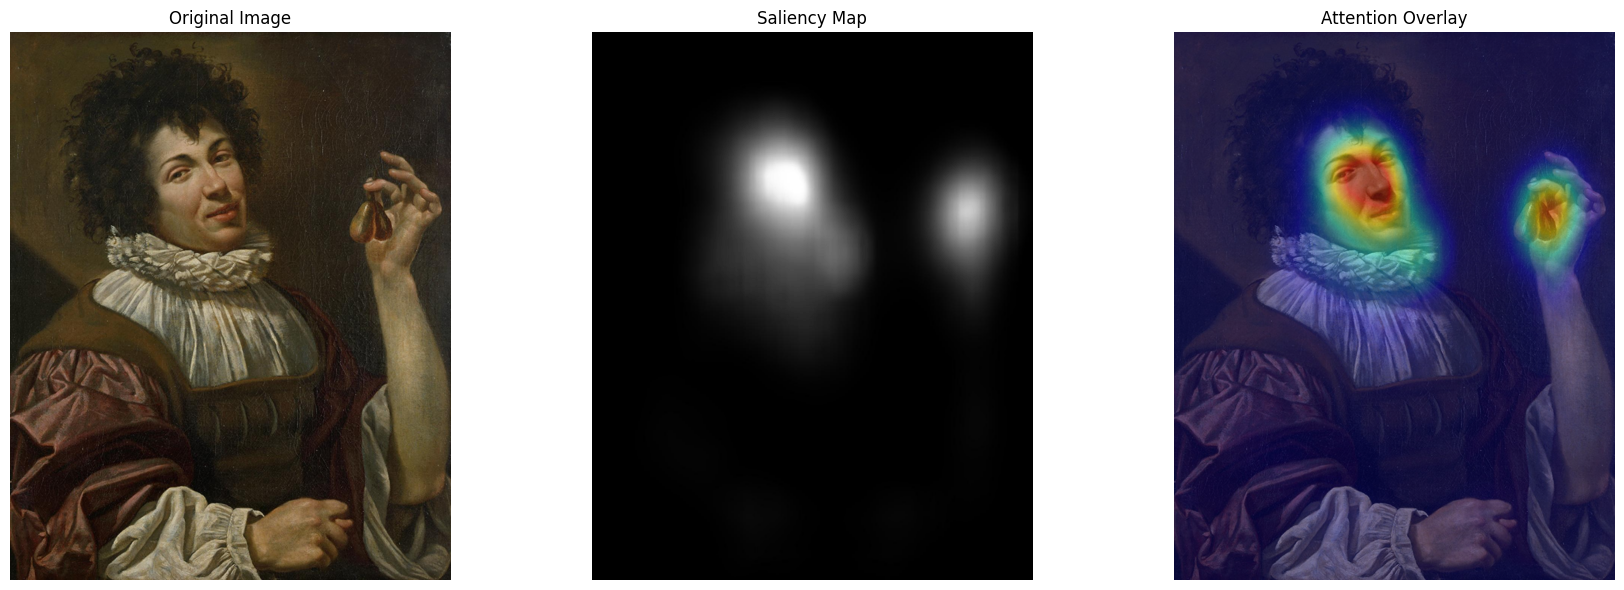

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_image_and_saliency(img_path, saliency_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0

    if saliency.shape != image.shape[:2]:
        saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))

    heatmap = cv2.applyColorMap((saliency * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(saliency, cmap='gray')
    axes[1].set_title("Saliency Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Attention Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
    img_path = f'paintings_all/{img_name}'
    saliency_path = f'paintings_saliency_salicon/{img_name}'

    visualize_image_and_saliency(img_path, saliency_path)


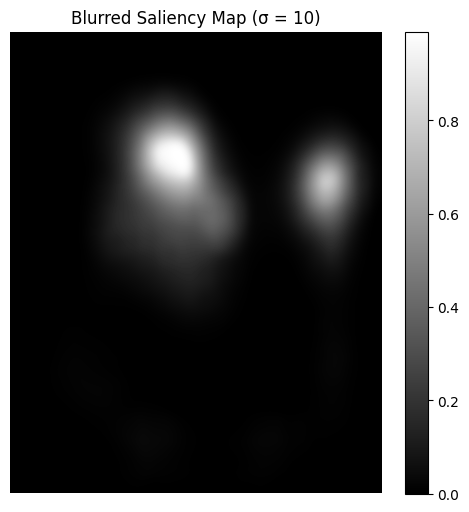

In [12]:
def show_blurred_saliency(img_path, saliency_path, blur_sigma=10):
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if saliency.shape != image.shape[:2]:
        saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))

    smoothed_saliency = gaussian_filter(saliency, sigma=blur_sigma)

    plt.figure(figsize=(6, 6))
    plt.imshow(smoothed_saliency, cmap='gray')
    plt.title(f"Blurred Saliency Map (σ = {blur_sigma})")
    plt.axis('off')
    plt.colorbar()
    plt.show()

if __name__ == "__main__":
    img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
    img_path = f'paintings_all/{img_name}'
    saliency_path = f'paintings_saliency_salicon/{img_name}'

    show_blurred_saliency(img_path, saliency_path, blur_sigma=10)


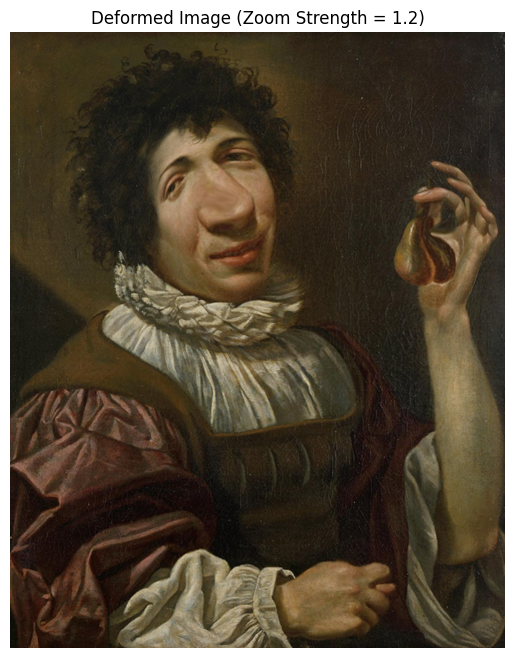

In [13]:
def show_deformed_image_only(img_path, saliency_path, zoom_strength=1.0):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0

    deformer = SaliencyDeformer(image, saliency)
    deformed = deformer.zoom_deformation(zoom_strength=zoom_strength, local_centers=True)

    plt.figure(figsize=(8, 8))
    plt.imshow(deformed)
    plt.axis("off")
    plt.title(f"Deformed Image (Zoom Strength = {zoom_strength})")
    plt.show()

if __name__ == "__main__":
    img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
    img_path = f'paintings_all/{img_name}'
    saliency_path = f'paintings_saliency_salicon/{img_name}'

    show_deformed_image_only(img_path, saliency_path, zoom_strength=1.2)


In [15]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

def generate_progressive_deformation_video(img_path, sal_path, output_path="output.mp4", 
                                            steps=30, max_zoom=1.5, fps=15):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0
    deformer = SaliencyDeformer(image, saliency)

    height, width = image.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print("Generating frames...")

    for i in range(steps + 1):
        zoom_strength = (i / steps) * max_zoom

        frame = deformer.zoom_deformation(zoom_strength=zoom_strength, local_centers=True)
        frame_bgr = (frame * 255).astype(np.uint8)
        frame_bgr = cv2.cvtColor(frame_bgr, cv2.COLOR_RGB2BGR)

        video.write(frame_bgr)

        print(f"Frame {i+1}/{steps + 1} written (zoom_strength={zoom_strength:.2f})")

    video.release()
    print(f"Video saved to: {output_path}")

if __name__ == "__main__":
    #img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
    img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
    img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
    img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'
    img_name = 'FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg'
    #img_name = "MANFREDI Bartoloméo, Soldats jouant aux cartes Inv.61.jpg"
    img_name = 'Survage, Vision surréaliste Inv.81.16.10.jpg'
    img_path = f"paintings_all/{img_name}"
    sal_path = f"paintings_saliency_salicon/{img_name}"

    generate_progressive_deformation_video(
        img_path,
        sal_path,
        output_path="survage.mp4",
        steps=2,
        max_zoom=2.5,
        fps=15
    )


Generating frames...
Frame 1/3 written (zoom_strength=0.00)
Frame 2/3 written (zoom_strength=1.25)
Frame 3/3 written (zoom_strength=2.50)
Video saved to: survage.mp4


NameError: name 'verlay_saliency_on_image' is not defined

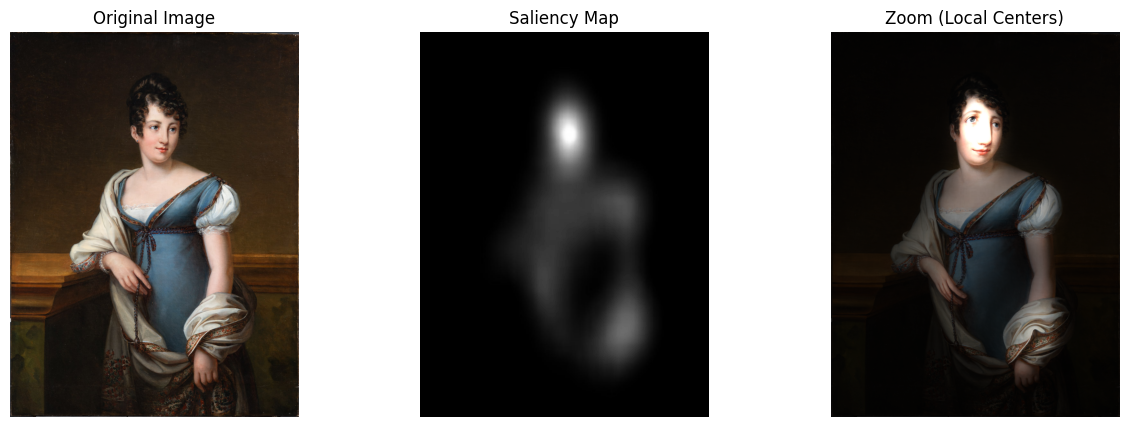

In [16]:
class SaliencyDeformer:
    def __init__(self, image, saliency_map):
        """
        Initialize the deformer with an image and its saliency map.
        
        Args:
            image: RGB image (H, W, 3) with values in [0, 255] or [0, 1]
            saliency_map: Grayscale saliency map (H, W) with values in [0, 1]
        """
        if image.max() > 1:
            self.image = image.astype(np.float32) / 255.0
        else:
            self.image = image.astype(np.float32)
        self.saliency = np.clip(saliency_map.astype(np.float32), 0, 1)
        
        if self.saliency.shape != self.image.shape[:2]:
            self.saliency = cv2.resize(self.saliency, 
                                    (self.image.shape[1], self.image.shape[0]),
                                    interpolation=cv2.INTER_LINEAR)
        
        self.height, self.width = self.image.shape[:2]
    
    def _interpolate_image(self, new_y, new_x):
        """
        Interpolate the image using the new coordinate mappings.
        """
        new_y = np.clip(new_y, 0, self.height - 1)
        new_x = np.clip(new_x, 0, self.width - 1)
        if len(self.image.shape) == 3:
            deformed = np.zeros_like(self.image)
            for c in range(self.image.shape[2]):
                deformed[:, :, c] = map_coordinates(
                    self.image[:, :, c], 
                    [new_y, new_x], 
                    order=1, 
                    mode='reflect'
                )
        else:
            deformed = map_coordinates(
                self.image, 
                [new_y, new_x], 
                order=1, 
                mode='reflect'
            )
        
        return np.clip(deformed, 0, 1)
    
    def _find_local_saliency_centers(self, blur_sigma):
        """
        Find local centers of high saliency for each pixel.
        This creates a field where each pixel points to its nearest high-saliency center.
        """
        smoothed_saliency = gaussian_filter(self.saliency, sigma=blur_sigma)
        
        local_maxima = maximum_filter(smoothed_saliency, size=int(blur_sigma * 2)) == smoothed_saliency
        local_maxima = local_maxima & (smoothed_saliency > 0.3)
        
        max_coords = np.where(local_maxima)
        max_y = max_coords[0]
        max_x = max_coords[1]
        max_values = smoothed_saliency[max_y, max_x]
        
        if len(max_y) == 0:
            center_y = np.full((self.height, self.width), self.height // 2, dtype=np.float32)
            center_x = np.full((self.height, self.width), self.width // 2, dtype=np.float32)
            return center_y, center_x
        
        y_grid, x_grid = np.mgrid[0:self.height, 0:self.width]
        center_y = np.zeros((self.height, self.width), dtype=np.float32)
        center_x = np.zeros((self.height, self.width), dtype=np.float32)
        
        for i in range(self.height):
            for j in range(self.width):
                distances = np.sqrt((max_y - i)**2 + (max_x - j)**2)
                
                weights = max_values / (distances + 1e-6)
                weights = weights / np.sum(weights)
                
                center_y[i, j] = np.sum(weights * max_y)
                center_x[i, j] = np.sum(weights * max_x)
        
        return center_y, center_x
    
    def zoom_deformation(self, zoom_strength=0.5, blur_sigma=5, local_centers=True):
        """
        Apply zoom effect to salient regions - expands high-saliency areas.
        
        Args:
            zoom_strength: How strong the zoom effect is (0.1 to 2.0)
            blur_sigma: Gaussian blur for smoothing the deformation field
            local_centers: If True, zoom around local saliency centers; if False, use global center
        """
        zoom_field = gaussian_filter(self.saliency, sigma=blur_sigma)
        zoom_field = zoom_field * zoom_strength + 1.0
        y, x = np.mgrid[0:self.height, 0:self.width]
        
        if local_centers:
            center_y, center_x = self._find_local_saliency_centers(blur_sigma * 2)
        else:
            center_y = np.full_like(y, self.height // 2, dtype=np.float32)
            center_x = np.full_like(x, self.width // 2, dtype=np.float32)
        
        dy = y - center_y
        dx = x - center_x
        
        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field
        
        deformed = self._interpolate_image(new_y, new_x)
        return deformed
    
    


def demonstrate_effects(img_path, sal_path):

    image = cv2.imread(img_path)
    brightness_strength = 0.8
    image = np.asarray(image).astype(np.float32) / 255.0
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0

    saliency = np.asarray(saliency).astype(np.float32)
    
    saliency = np.clip(saliency, 0, 1)
    factor = 1.0 + brightness_strength * (saliency - 0.5) * 2
    
    new_image = np.zeros_like(image)
    for c in range(3):
        new_image[:, :, c] = np.clip(image[:, :, c] * factor, 0, 1)

    deformer = SaliencyDeformer(new_image, saliency)
    
    zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(saliency, cmap='gray')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')
    
    axes[2].imshow(zoom_result)
    axes[2].set_title('Zoom (Local Centers)')
    axes[2].axis('off')
    verlay_saliency_on_image
    plt.tight_layout()
    plt.show()



img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_salicon/{img_name}'

demonstrate_effects(img_path, sal_path)

In [ ]:
class SaliencyDeformer:
    def __init__(self, image, saliency_map):
        """
        Initialize the deformer with an image and its saliency map.
        
        Args:
            image: RGB image (H, W, 3) with values in [0, 255] or [0, 1]
            saliency_map: Grayscale saliency map (H, W) with values in [0, 1]
        """
        if image.max() > 1:
            self.image = image.astype(np.float32) / 255.0
        else:
            self.image = image.astype(np.float32)
            
        self.saliency = np.clip(saliency_map.astype(np.float32), 0, 1)
        
        if self.saliency.shape != self.image.shape[:2]:
            self.saliency = cv2.resize(self.saliency, 
                                    (self.image.shape[1], self.image.shape[0]),
                                    interpolation=cv2.INTER_LINEAR)
        
        self.height, self.width = self.image.shape[:2]
    
    def _interpolate_image(self, new_y, new_x):
        """
        Interpolate the image using the new coordinate mappings.
        """
        new_y = np.clip(new_y, 0, self.height - 1)
        new_x = np.clip(new_x, 0, self.width - 1)
        
        if len(self.image.shape) == 3:
            deformed = np.zeros_like(self.image)
            for c in range(self.image.shape[2]):
                deformed[:, :, c] = map_coordinates(
                    self.image[:, :, c], 
                    [new_y, new_x], 
                    order=1, 
                    mode='reflect'
                )
        else:
            deformed = map_coordinates(
                self.image, 
                [new_y, new_x], 
                order=1, 
                mode='reflect'
            )
        
        return np.clip(deformed, 0, 1)
    
    def _find_local_saliency_centers(self, blur_sigma):
        """
        Find local centers of high saliency for each pixel.
        This creates a field where each pixel points to its nearest high-saliency center.
        """
        smoothed_saliency = gaussian_filter(self.saliency, sigma=blur_sigma)
        
        local_maxima = maximum_filter(smoothed_saliency, size=int(blur_sigma * 2)) == smoothed_saliency
        local_maxima = local_maxima & (smoothed_saliency > 0.3)
        
        max_coords = np.where(local_maxima)
        max_y = max_coords[0]
        max_x = max_coords[1]
        max_values = smoothed_saliency[max_y, max_x]
        
        if len(max_y) == 0:
            center_y = np.full((self.height, self.width), self.height // 2, dtype=np.float32)
            center_x = np.full((self.height, self.width), self.width // 2, dtype=np.float32)
            return center_y, center_x
        
        y_grid, x_grid = np.mgrid[0:self.height, 0:self.width]
        
        center_y = np.zeros((self.height, self.width), dtype=np.float32)
        center_x = np.zeros((self.height, self.width), dtype=np.float32)
        
        for i in range(self.height):
            for j in range(self.width):
                distances = np.sqrt((max_y - i)**2 + (max_x - j)**2)
                weights = max_values / (distances + 1e-6)
                weights = weights / np.sum(weights)
                center_y[i, j] = np.sum(weights * max_y)
                center_x[i, j] = np.sum(weights * max_x)
        
        return center_y, center_x
    
    def zoom_deformation(self, zoom_strength=0.5, blur_sigma=5, local_centers=True):
        """
        Apply zoom effect to salient regions - expands high-saliency areas.
        
        Args:
            zoom_strength: How strong the zoom effect is (0.1 to 2.0)
            blur_sigma: Gaussian blur for smoothing the deformation field
            local_centers: If True, zoom around local saliency centers; if False, use global center
        """
        zoom_field = gaussian_filter(self.saliency, sigma=blur_sigma)
        zoom_field = zoom_field * zoom_strength + 1.0
        y, x = np.mgrid[0:self.height, 0:self.width]
        
        if local_centers:
            center_y, center_x = self._find_local_saliency_centers(blur_sigma * 2)
        else:
            center_y = np.full_like(y, self.height // 2, dtype=np.float32)
            center_x = np.full_like(x, self.width // 2, dtype=np.float32)
        
        dy = y - center_y
        dx = x - center_x
        
        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field
        deformed = self._interpolate_image(new_y, new_x)
        return deformed
    
    


def demonstrate_effects(img_path, sal_path):
    image = cv2.imread(img_path)
    brightness_strength = 0.8  
    overlay_strength = 0.6  

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0
    
    saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE)
    saliency = cv2.resize(saliency, (image.shape[1], image.shape[0])) 
    saliency = np.clip(saliency.astype(np.float32) / 255.0, 0, 1) 
    
    saliency_color = cv2.applyColorMap((saliency * 255).astype(np.uint8), cv2.COLORMAP_JET)
    saliency_color = cv2.cvtColor(saliency_color, cv2.COLOR_BGR2RGB)
    saliency_color = saliency_color.astype(np.float32) / 255.0  # (H, W, 3)
    
    overlay = (1 - overlay_strength) * image + overlay_strength * saliency_color
    overlay = np.clip(overlay, 0, 1)

    deformer = SaliencyDeformer(overlay, saliency)
    zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(saliency, cmap='jet')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')
    
    axes[2].imshow(zoom_result)
    axes[2].set_title('Zoom (Local Centers)')
    axes[2].axis('off')
    verlay_saliency_on_image
    plt.tight_layout()
    plt.show()



img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_salicon/{img_name}'

demonstrate_effects(img_path, sal_path)

In [ ]:
#img_name = 'LEBASQUE Nu couché dans un paysage 81.16.4'
img_name = 'VOUET Simon, Jeune homme à la figue Inv.182'
#img_name = 'PRINET R.X, Au balcon de Venise Inv.35'
#img_name = 'HENNEQUIN Autoportrait 75.3.1'
#img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1'
#img_name = 'BRUEGHEL LE JEUNE Pierre, Le paiement de la dîme, Inv 22 '
#img_name = 'CRESPI Un marché 79.2.1'
#img_name = 'DENIS Au balcon de Venise D.75.1.13'
#img_name = 'FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47'
#img_name = 'MANFREDI Bartoloméo, Soldats jouant aux cartes Inv.61'
#img_name = 'Survage, Vision surréaliste Inv.81.16.10'

img_path = f'paintings_deformed_salicon/{img_name}.jpg'
sal_path = f'paintings_saliency_salicon/{img_name}.jpg'
image_path = img_path
saliency_path = sal_path
brightness_strength = 0.6 

image = Image.open(image_path).convert("RGB")
image = np.asarray(image).astype(np.float32) / 255.0 

saliency = Image.open(saliency_path).convert("L")
saliency = np.asarray(saliency).astype(np.float32) / 255.0 

saliency = np.clip(saliency, 0, 1)
factor = 1.0 + brightness_strength * (saliency - 0.5) * 2 

new_image = np.zeros_like(image)
for c in range(3):
    new_image[:, :, c] = np.clip(image[:, :, c] * factor, 0, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Carte de saillance")
plt.imshow(saliency, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Image modifiée")
plt.imshow(new_image)
plt.axis("off")

plt.tight_layout()
plt.show()

new_image_uint8 = (new_image * 255).astype(np.uint8)

new_image_pil = Image.fromarray(new_image_uint8)

new_image_pil.save(img_name+'avecSaillanceGrise.jpg')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates, maximum_filter
import os

class SaliencyDeformer:
    def __init__(self, image, saliency_map):
        if image.max() > 1:
            self.image = image.astype(np.float32) / 255.0
        else:
            self.image = image.astype(np.float32)

        self.saliency = np.clip(saliency_map.astype(np.float32), 0, 1)

        if self.saliency.shape != self.image.shape[:2]:
            self.saliency = cv2.resize(self.saliency,
                                       (self.image.shape[1], self.image.shape[0]),
                                       interpolation=cv2.INTER_LINEAR)

        self.height, self.width = self.image.shape[:2]

    def _interpolate_image(self, new_y, new_x):
        new_y = np.clip(new_y, 0, self.height - 1)
        new_x = np.clip(new_x, 0, self.width - 1)
        deformed = np.zeros_like(self.image)
        for c in range(self.image.shape[2]):
            deformed[:, :, c] = map_coordinates(
                self.image[:, :, c],
                [new_y, new_x],
                order=1,
                mode='reflect'
            )
        return np.clip(deformed, 0, 1)

    def _find_saliency_centers(self, blur_sigma=10):
        smoothed = gaussian_filter(self.saliency, sigma=blur_sigma)
        local_max = (maximum_filter(smoothed, size=blur_sigma * 2) == smoothed)
        local_max = local_max & (smoothed > 0.3)
        max_y, max_x = np.where(local_max)
        return max_y, max_x

    def _build_center_map(self, max_y, max_x):
        y_grid, x_grid = np.mgrid[0:self.height, 0:self.width]
        center_y = np.zeros((self.height, self.width), dtype=np.float32)
        center_x = np.zeros((self.height, self.width), dtype=np.float32)

        for i in range(self.height):
            for j in range(self.width):
                dists = np.sqrt((max_y - i) ** 2 + (max_x - j) ** 2)
                weights = 1 / (dists + 1e-6)
                weights = weights / np.sum(weights)
                center_y[i, j] = np.sum(weights * max_y)
                center_x[i, j] = np.sum(weights * max_x)

        return center_y, center_x

    def deform(self, alpha, max_y, max_x, zoom_strength=0.8):
        zoom_field = self.saliency * (zoom_strength * alpha) + 1.0
        y, x = np.mgrid[0:self.height, 0:self.width]
        center_y, center_x = self._build_center_map(max_y, max_x)
        dy = y - center_y
        dx = x - center_x
        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field
        return self._interpolate_image(new_y, new_x)

def blend_with_saliency(image, saliency):
    saliency_color = np.repeat(saliency[:, :, np.newaxis], 3, axis=2)
    return 0.5 * image + 0.5 * saliency_color

def generate_full_video(image_path, saliency_path, output_path='full_deformation.mp4'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0
    height, width = image.shape[:2]

    deformer = SaliencyDeformer(image, saliency)
    max_y, max_x = deformer._find_saliency_centers()

    fps = 30
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    print("1. Phase 1 : Image + saliency overlay")
    overlay = blend_with_saliency(deformer.image, saliency)
    maxim=10
    for _ in range(maxim):
        frame = overlay.copy()
        frame_bgr = (frame * 255).astype(np.uint8)[..., ::-1]
        writer.write(frame_bgr)

    print("2. Phase 2 : Saliency se concentre et les points blancs apparaissent progressivement")
    maxim=40
    for i in range(maxim):
        sigma = 1 + i * 2
        blurred = gaussian_filter(saliency, sigma=sigma)
    
        threshold = 0.9 * blurred.max()
        mask = (blurred > threshold).astype(np.float32)
        fade = 1 - (i / (maxim-1))
    
        saliency_rgb = np.repeat((blurred * fade)[:, :, np.newaxis], 3, axis=2)
        frame = 0.5 * deformer.image + 0.5 * saliency_rgb
        frame = np.clip(frame, 0, 1)
    
        frame_bgr = np.ascontiguousarray((frame * 255).astype(np.uint8)[..., ::-1])
    
        overlay = frame_bgr.copy()
        alpha_point = i / (maxim-1) 
    
        for y, x in zip(max_y, max_x):
            cv2.circle(overlay, (int(x), int(y)), 3, (255, 255, 255), -1)
    
        frame_bgr = cv2.addWeighted(overlay, alpha_point, frame_bgr, 1 - alpha_point, 0)
    
        writer.write(frame_bgr)


    print("3. Phase 3 : Image normale avec points blancs")
    maxim=10
    for _ in range(maxim):
        frame = deformer.image.copy()
        frame_bgr = np.ascontiguousarray((frame * 255).astype(np.uint8)[..., ::-1])
        for y, x in zip(max_y, max_x):
            cv2.circle(frame_bgr, (int(x), int(y)), 3, (255, 255, 255), -1)
        writer.write(frame_bgr)

    print("4. Phase 4 : Déformation progressive")
    maxim=50
    for i in range(maxim):
        alpha = i / (maxim-1)
        deformed = deformer.deform(alpha, max_y, max_x)
        frame_bgr = np.ascontiguousarray((deformed * 255).astype(np.uint8)[..., ::-1])

        for y, x in zip(max_y, max_x):
            cv2.circle(frame_bgr, (int(x), int(y)), 3, (255, 255, 255), -1)
        writer.write(frame_bgr)


    print("out")

    for _ in range(15):
        print("_", _)
        writer.write(frame_bgr)

    writer.release()
    print(f"✅ Vidéo enregistrée : {output_path}")

if __name__ == '__main__':
    img = 'paintings_all/Survage, Vision surréaliste Inv.81.16.10.jpg'
    sal = 'paintings_saliency_salicon/Survage, Vision surréaliste Inv.81.16.10.jpg'
    generate_full_video(img, sal, 'final_deformation_video.mp4')


In [17]:
import cv2
import numpy as np

def generate_scan_path_s_pattern(saliency, total_frames, width, height, line_count=20):
    """
    Génère un chemin en S (balayage ligne par ligne), en ralentissant
    dans les zones de forte saillance.
    """
    step_y = height // line_count
    points = []

    for i in range(line_count):
        y = step_y * i + step_y // 2
        x_range = range(width) if i % 2 == 0 else range(width - 1, -1, -1)

        for x in x_range:
            s = saliency[y % height, x % width]
            duration = int(2 + 10 * s) 
            points.extend([(x, y)] * duration)

    if len(points) > total_frames:
        indices = np.linspace(0, len(points) - 1, total_frames).astype(int)
        path = [points[i] for i in indices]
    else:
        path = points + [points[-1]] * (total_frames - len(points))

    return path

def visual_scan_with_saliency(image_path, saliency_path, output_path='scan_s_pattern.mp4', duration_sec=6, fps=30):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))

    height, width = image.shape[:2]
    total_frames = duration_sec * fps
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    path = generate_scan_path_s_pattern(saliency, total_frames, width, height)

    for i, (x, y) in enumerate(path):
        alpha = max(0, 1 - i / total_frames)
        saliency_color = np.repeat(saliency[:, :, np.newaxis], 3, axis=2)
        overlay = (1 - 0.5 * alpha) * image + 0.5 * alpha * saliency_color

        frame_bgr = np.ascontiguousarray((overlay * 255).astype(np.uint8)[..., ::-1])
        cv2.circle(frame_bgr, (x, y), 5, (255, 255, 255), -1)

        writer.write(frame_bgr)

    writer.release()
    print(f"✅ Vidéo enregistré dans : {output_path}")

visual_scan_with_saliency(
    image_path='paintings_all/DENIS Au balcon de Venise D.75.1.13.jpg',
    saliency_path='paintings_saliency_salicon/DENIS Au balcon de Venise D.75.1.13.jpg',
    output_path='scan_s_pattern.mp4'
)


✅ Vidéo enregistré dans : scan_s_pattern.mp4


In [18]:
import cv2
import numpy as np
import random

def generate_random_fixation_path(saliency, total_frames, step_radius=30, saliency_threshold=0.2):
    """
    Génère une trajectoire pseudo-aléatoire en favorisant les zones saillantes,
    et en évitant les zones sombres (sous le seuil).
    """
    height, width = saliency.shape
    current_y, current_x = random.randint(0, height - 1), random.randint(0, width - 1)

    sal = saliency.copy()
    sal[sal < saliency_threshold] = 0
    sal /= (sal.sum() + 1e-8) 

    path = []

    for _ in range(total_frames):
        candidates = []
        weights = []

        for dy in range(-step_radius, step_radius + 1):
            for dx in range(-step_radius, step_radius + 1):
                ny, nx = current_y + dy, current_x + dx
                if 0 <= ny < height and 0 <= nx < width and dy**2 + dx**2 <= step_radius**2:
                    if sal[ny, nx] > 0:
                        candidates.append((nx, ny))
                        weights.append(sal[ny, nx])

        if candidates:
            probs = np.array(weights) / np.sum(weights)
            current_x, current_y = candidates[np.random.choice(len(candidates), p=probs)]
        else:
            valid = np.argwhere(sal > 0)
            if len(valid) > 0:
                current_y, current_x = valid[np.random.randint(len(valid))]

        path.append((current_x, current_y))

    return path

def visual_scan_with_random_path(image_path, saliency_path, output_path='scan_random.mp4', duration_sec=6, fps=30):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))

    height, width = image.shape[:2]
    total_frames = duration_sec * fps
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    path = generate_random_fixation_path(saliency, total_frames)

    for i, (x, y) in enumerate(path):
        alpha = max(0, 1 - i / total_frames)
        saliency_color = np.repeat(saliency[:, :, np.newaxis], 3, axis=2)
        overlay = (1 - 0.5 * alpha) * image + 0.5 * alpha * saliency_color

        frame_bgr = np.ascontiguousarray((overlay * 255).astype(np.uint8)[..., ::-1])
        cv2.circle(frame_bgr, (x, y), 5, (255, 255, 255), -1)

        writer.write(frame_bgr)

    writer.release()
    print(f"✅ Vidéo enregistré : {output_path}")

visual_scan_with_random_path(
    image_path='paintings_all/DENIS Au balcon de Venise D.75.1.13.jpg',
    saliency_path='paintings_saliency_salicon/DENIS Au balcon de Venise D.75.1.13.jpg',
    output_path='scan_random.mp4'
)


✅ Vidéo enregistré : scan_random.mp4


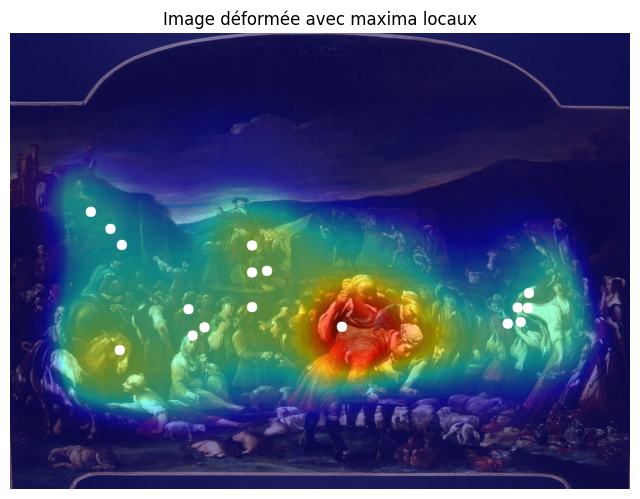

True

In [19]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter, gaussian_filter
import matplotlib.pyplot as plt

def find_local_maxima(saliency, blur_sigma=5, threshold=0.3):
    """
    Trouve les maxima locaux sur une carte de saillance floutée.
    """
    saliency_blurred = gaussian_filter(saliency, sigma=blur_sigma)
    local_max = maximum_filter(saliency_blurred, size=blur_sigma*2) == saliency_blurred
    local_max &= saliency_blurred > threshold
    return np.where(local_max)

def overlay_maxima_on_image(image, saliency, deformer):
    """
    Affiche l'image déformée avec les maxima locaux de la carte de saillance.
    """
    deformed = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)
    max_y, max_x = find_local_maxima(saliency)
    img_display = (deformed * 255).astype(np.uint8).copy()
    for y, x in zip(max_y, max_x):
        cv2.circle(img_display, (int(x), int(y)), 10, (255, 255, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.title("Image déformée avec maxima locaux")
    plt.axis('off')
    plt.show()
    return img_display

image_path='paintings_superimposed_salicon/CRESPI Un marché 79.2.1.jpg'
saliency_path='paintings_saliency_salicon/CRESPI Un marché 79.2.1.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0

deformer = SaliencyDeformer(image, saliency)

image_bgr_uint8=overlay_maxima_on_image(image, saliency, deformer)
image_bgr = image_bgr_uint8[..., ::-1]
cv2.imwrite('deformeMaximalPoint.jpg', image_bgr)

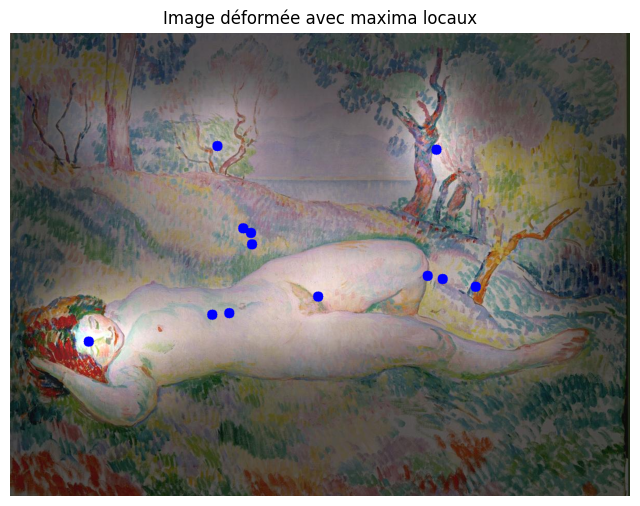

True

In [22]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter, gaussian_filter
import matplotlib.pyplot as plt

def find_local_maxima(saliency, blur_sigma=5, threshold=0.3):
    """
    Trouve les maxima locaux sur une carte de saillance floutée.
    """
    saliency_blurred = gaussian_filter(saliency, sigma=blur_sigma)
    local_max = maximum_filter(saliency_blurred, size=blur_sigma*2) == saliency_blurred
    local_max &= saliency_blurred > threshold
    return np.where(local_max)

def overlay_maxima_on_image(image, saliency, deformer):
    """
    Affiche l'image déformée avec les maxima locaux de la carte de saillance.
    """
    max_y, max_x = find_local_maxima(saliency)

    img_display = image
    for y, x in zip(max_y, max_x):
        cv2.circle(img_display, (int(x), int(y)), 10, (0, 0, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.title("Image déformée avec maxima locaux")
    plt.axis('off')
    plt.show()
    return img_display

image_path='vidéo/avecSaillanceGrise.jpg'
saliency_path='paintings_saliency_salicon/LEBASQUE Nu couché dans un paysage 81.16.4.jpg'



image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0

deformer = SaliencyDeformer(image, saliency)

image_bgr_uint8=overlay_maxima_on_image(image, saliency, deformer)
image_bgr = image_bgr_uint8[..., ::-1]
cv2.imwrite('saliencymaxPoint.jpg', image_bgr)

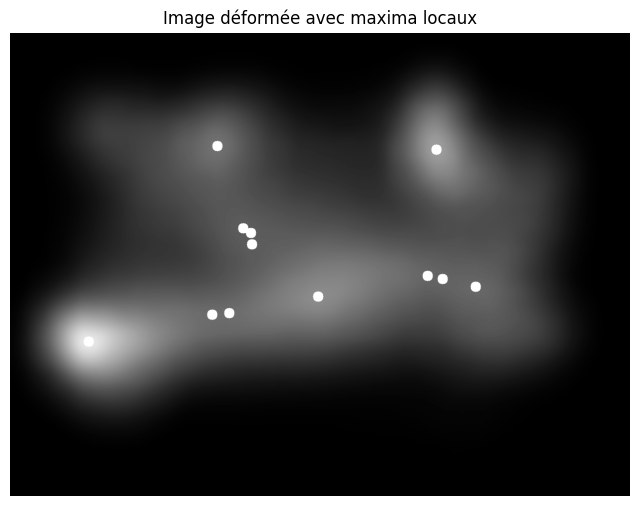

True

In [23]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter, gaussian_filter
import matplotlib.pyplot as plt

def find_local_maxima(saliency, blur_sigma=5, threshold=0.3):
    """
    Trouve les maxima locaux sur une carte de saillance floutée.
    """
    saliency_blurred = gaussian_filter(saliency, sigma=5)
    local_max = maximum_filter(saliency_blurred, size=blur_sigma*2) == saliency_blurred
    local_max &= saliency_blurred > threshold
    return np.where(local_max)

def overlay_maxima_on_image(image, saliency, deformer):
    """
    Affiche l'image déformée avec les maxima locaux de la carte de saillance.
    """
    max_y, max_x = find_local_maxima(saliency)

    img_display = gaussian_filter(image, sigma=10)
    for y, x in zip(max_y, max_x):
        cv2.circle(img_display, (int(x), int(y)), 10, (255, 255, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.title("Image déformée avec maxima locaux")
    plt.axis('off')
    plt.show()
    return img_display

image_path='paintings_saliency_salicon/LEBASQUE Nu couché dans un paysage 81.16.4.jpg'
saliency_path='paintings_saliency_salicon/LEBASQUE Nu couché dans un paysage 81.16.4.jpg'



image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE) / 255.0

deformer = SaliencyDeformer(image, saliency)

image_bgr_uint8=overlay_maxima_on_image(image, saliency, deformer)
image_bgr = image_bgr_uint8[..., ::-1]
cv2.imwrite('saliencyblourmaxpoint.jpg', image_bgr)

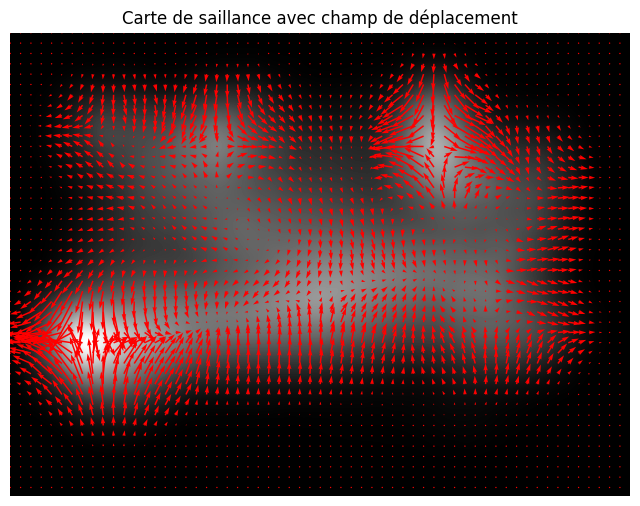

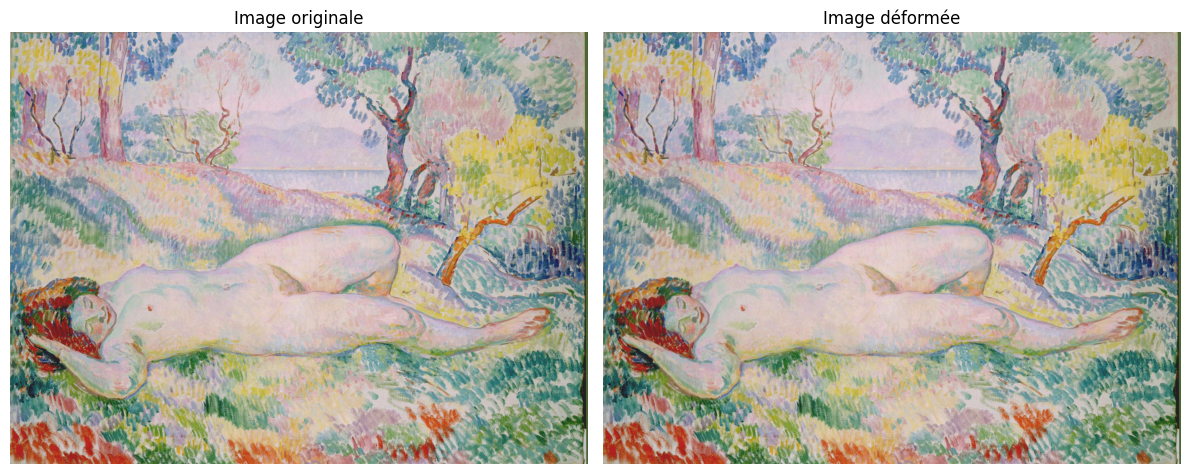

True

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter

img_name = 'LEBASQUE Nu couché dans un paysage 81.16.4.jpg'
image_path = f'paintings_all/{img_name}'
saliency_path = f'paintings_saliency_salicon/{img_name}'

image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
saliency = np.array(Image.open(saliency_path).convert("L")).astype(np.float32) / 255.0

H, W = saliency.shape
saliency_blur = gaussian_filter(saliency, sigma=8)
grad_y, grad_x = np.gradient(saliency_blur)

scale = 100 
disp_x = -scale * grad_x
disp_y = -scale * grad_y

step = 20
plt.figure(figsize=(8, 8))
plt.imshow(saliency_blur, cmap='gray')
plt.quiver(
    np.arange(0, W, step),
    np.arange(0, H, step),
    disp_x[::step, ::step],
    -disp_y[::step, ::step],
    color='red', angles='xy'
)
plt.title("Carte de saillance avec champ de déplacement")
plt.axis("off")
plt.show()

coords_x, coords_y = np.meshgrid(np.arange(W), np.arange(H))
map_x = np.clip((coords_x + disp_x).astype(np.float32), 0, W - 1)
map_y = np.clip((coords_y + disp_y).astype(np.float32), 0, H - 1)

image_bgr = (image * 255).astype(np.uint8)[..., ::-1]

deformed = cv2.remap(image_bgr, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image déformée")
plt.imshow(deformed[..., ::-1])
plt.axis("off")

plt.tight_layout()
plt.show()

cv2.imwrite("carteDeformé.jpg", deformed)


In [ ]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image

fps = 30
dur_phase1 = 3.8 
dur_phase2 = 2.8
dur_phase3 = 3.5  
frame_counts = [int(fps * t) for t in (dur_phase1, dur_phase2, dur_phase3)]

img_path = 'paintings_all/Survage, Vision surréaliste Inv.81.16.10.jpg'
sal_path = 'paintings_saliency_salicon/Survage, Vision surréaliste Inv.81.16.10.jpg'

image = Image.open(img_path).convert("RGB")
image = np.asarray(image).astype(np.float32) / 255.0
saliency = Image.open(sal_path).convert("L")
saliency = np.asarray(saliency).astype(np.float32) / 255.0
H, W = saliency.shape
deformer = SaliencyDeformer(image, saliency)
writer = cv2.VideoWriter("video_output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))

def colorize_saliency(sal):
    heatmap = cv2.applyColorMap((sal * 255).astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap[..., ::-1].astype(np.float32) / 255.0

def deform_image(image, saliency, strength=0.2, blur_sigma=20):
    saliency_blur = gaussian_filter(saliency, sigma=blur_sigma)
    grad_y, grad_x = np.gradient(saliency_blur)
    disp_x = -grad_x * strength
    disp_y = -grad_y * strength

    map_x, map_y = np.meshgrid(np.arange(W), np.arange(H))
    map_x = np.clip((map_x + disp_x).astype(np.float32), 0, W - 1)
    map_y = np.clip((map_y + disp_y).astype(np.float32), 0, H - 1)

    deformed = cv2.remap((image * 255).astype(np.uint8), map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return deformed.astype(np.float32) / 255.0

sal_colored = colorize_saliency(saliency)
for i in range(frame_counts[0]):
    alpha = i / frame_counts[0]
    blended = (1 - alpha) * image + alpha * sal_colored
    frame_bgr = (blended * 255).astype(np.uint8)[..., ::-1]
    writer.write(frame_bgr)

for i in range(frame_counts[1]):
    fade = 1 - i / frame_counts[1]
    strength = 0.05 + 0.1 * (i / frame_counts[1])
    sal_blend = sal_colored * fade
    pre_deform = (1 - fade) * image + fade * sal_blend
    deformed = deformer.zoom_deformation(zoom_strength=strength, local_centers=True)
    frame_bgr = (deformed * 255).astype(np.uint8)[..., ::-1]
    writer.write(frame_bgr)

for i in range(frame_counts[2]):
    strength = 0.15 + 0.05 * (i / frame_counts[2])
    deformed = deformer.zoom_deformation(zoom_strength=strength, local_centers=True)
    frame_bgr = (deformed * 255).astype(np.uint8)[..., ::-1]
    writer.write(frame_bgr)

writer.release()
print("✅ Vidéo enregistrée : vidéotransformationsaillancepuisdeformation.mp4")


In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates, maximum_filter
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


image_path = "paintings_all/duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg"
saliency_path = "paintings_saliency_salicon/duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg"


image = cv2.imread(image_path)
saliency_map = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE)
saliency_map = cv2.resize(saliency_map, (image.shape[1], image.shape[0]))

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

saliency_norm = saliency_map.astype(np.float32) / 255.0
min_factor = 0.1
max_factor = 4
saturation_factor = min_factor + (max_factor - min_factor) * saliency_norm

s_modified = (s.astype(np.float32) * saturation_factor).clip(0, 255).astype(np.uint8)

hsv_modified = cv2.merge([h, s_modified, v])
image_modified = cv2.cvtColor(hsv_modified, cv2.COLOR_HSV2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='gray')
plt.title("Carte de saillance")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_modified)
plt.title("Image modifiée (saturation)")
plt.axis('off')

plt.tight_layout()
plt.show()


cv2.imwrite("image_saturation_modifiee.jpg", cv2.cvtColor(image_modified, cv2.COLOR_RGB2BGR))

print("✅ Image sauvegardée : image_superposee_rouge.jpg")


In [ ]:
import numpy as np
import cv2
from scipy.ndimage import map_coordinates

def wave_deformation(image, saliency, wave_freq=20, max_amplitude=20):
    H, W = saliency.shape
    Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    amplitude = max_amplitude * saliency
    disp_x = amplitude * np.sin(2 * np.pi * Y / wave_freq)
    disp_y = amplitude * np.cos(2 * np.pi * X / wave_freq)

    map_x = np.clip(X + disp_x, 0, W - 1)
    map_y = np.clip(Y + disp_y, 0, H - 1)

    remapped = cv2.remap((image * 255).astype(np.uint8), 
                         map_x.astype(np.float32), 
                         map_y.astype(np.float32), 
                         interpolation=cv2.INTER_LINEAR)
    return remapped.astype(np.float32) / 255.0

image_path = "paintings_all/HENNEQUIN Autoportrait 75.3.1.jpg"
saliency_path = "paintings_saliency_salicon/HENNEQUIN Autoportrait 75.3.1.jpg"

image = np.asarray(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
saliency = np.asarray(Image.open(saliency_path).convert("L")).astype(np.float32) / 255.0

result = wave_deformation(image, saliency)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image originale")
plt.imshow(image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Déformation en vagues liée à la saillance")
plt.imshow(result)
plt.axis('off')
plt.show()

cv2.imwrite("image_vague_modifiee.jpg", cv2.cvtColor(result*255, cv2.COLOR_RGB2BGR))

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter, distance_transform_edt
from PIL import Image

def find_local_maxima(saliency, size=10):
    max_filt = maximum_filter(saliency, size=size)
    maxima = (saliency == max_filt) & (saliency > 0.2)
    y, x = np.nonzero(maxima)
    return y, x

def bubble_deformation(image, saliency, bubble_max_radius=50):
    H, W = saliency.shape
    Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    maxima_y, maxima_x = find_local_maxima(saliency)
    deformation_map = np.zeros((H, W), dtype=np.float32)

    print("# Calcule distance au plus proche maximum local")
    if len(maxima_x) == 0:
        return image 

    mask = np.zeros_like(saliency, dtype=bool)
    mask[maxima_y, maxima_x] = True
    dist_map = distance_transform_edt(~mask)

    print("# Inverse la distance en amplitude bulle (plus proche → bulle plus grosse)")
    amplitude = np.clip(bubble_max_radius - dist_map, 0, bubble_max_radius)
    amplitude_norm = amplitude / bubble_max_radius

    print("# Déformation radiale autour des maxima : zoom local variable")
    disp_x = np.zeros_like(saliency)
    disp_y = np.zeros_like(saliency)

    for y_c, x_c in zip(maxima_y, maxima_x):
        dist = np.sqrt((Y - y_c) ** 2 + (X - x_c) ** 2)
        mask_bubble = dist < bubble_max_radius
        zoom_factor = 1 + (bubble_max_radius - dist[mask_bubble]) / bubble_max_radius * 0.3

        disp_x[mask_bubble] += (X[mask_bubble] - x_c) * (zoom_factor - 1)
        disp_y[mask_bubble] += (Y[mask_bubble] - y_c) * (zoom_factor - 1)
    print("finito")
    map_x = np.clip(X - disp_x, 0, W - 1)
    map_y = np.clip(Y - disp_y, 0, H - 1)

    remapped = cv2.remap((image * 255).astype(np.uint8), 
                        map_x.astype(np.float32), 
                        map_y.astype(np.float32), 
                        interpolation=cv2.INTER_LINEAR)
    return remapped.astype(np.float32) / 255.0

image_path = "paintings_all/PRINET R.X, Au balcon de Venise Inv.35.jpg"
saliency_path = "paintings_saliency_salicon/PRINET R.X, Au balcon de Venise Inv.35.jpg"

image = np.asarray(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
saliency = np.asarray(Image.open(saliency_path).convert("L")).astype(np.float32) / 255.0

result = bubble_deformation(image, saliency)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image originale")
plt.imshow(image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Déformation bulles centrée sur maxima locaux")
plt.imshow(result)
plt.axis('off')
plt.show()


In [ ]:
cv2.imwrite("image_vague_modifiee.jpg", cv2.cvtColor(result*255, cv2.COLOR_RGB2BGR))

In [ ]:
import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter, maximum_filter

class BreathingZoom:
    def __init__(self, image, saliency):
        self.image = image
        self.saliency = saliency
        self.height, self.width = saliency.shape

    def _find_local_saliency_centers(self, sigma=10, threshold=0.3):
        blurred = gaussian_filter(self.saliency, sigma=sigma)
        local_max = maximum_filter(blurred, size=sigma*2) == blurred
        local_max &= blurred > threshold
        center_y, center_x = np.where(local_max)
        if len(center_y) == 0:
            return (np.full((self.height, self.width), self.height // 2, dtype=np.float32),
                    np.full((self.width, self.width), self.width // 2, dtype=np.float32))
        yy, xx = np.meshgrid(np.arange(self.height), np.arange(self.width), indexing='ij')
        center_map_y = np.zeros_like(self.saliency, dtype=np.float32)
        center_map_x = np.zeros_like(self.saliency, dtype=np.float32)
        for y in range(self.height):
            for x in range(self.width):
                distances = (center_y - y) ** 2 + (center_x - x) ** 2
                i = np.argmin(distances)
                center_map_y[y, x] = center_y[i]
                center_map_x[y, x] = center_x[i]
        return center_map_y, center_map_x

    def _interpolate_image(self, new_y, new_x):
        new_x = np.clip(new_x, 0, self.width - 1).astype(np.float32)
        new_y = np.clip(new_y, 0, self.height - 1).astype(np.float32)
        img_uint8 = (self.image * 255).astype(np.uint8)
        deformed = cv2.remap(img_uint8, new_x, new_y, interpolation=cv2.INTER_LINEAR)
        return deformed.astype(np.float32) / 255.0

    def zoom_deformation(self, zoom_strength=0.5, blur_sigma=5, local_centers=True):
        zoom_field = gaussian_filter(self.saliency, sigma=blur_sigma)
        zoom_field = zoom_field * zoom_strength + 1.0

        y, x = np.mgrid[0:self.height, 0:self.width]

        if local_centers:
            center_y, center_x = self._find_local_saliency_centers(blur_sigma * 2)
        else:
            center_y = np.full_like(y, self.height // 2, dtype=np.float32)
            center_x = np.full_like(x, self.width // 2, dtype=np.float32)

        dy = y - center_y
        dx = x - center_x

        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field

        return self._interpolate_image(new_y, new_x)

    def generate_breathing_video(self, output_path='zoom_breathing.mp4', duration=4, fps=24, zoom_amplitude=0.5):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_path, fourcc, fps, (self.width, self.height))
        frames = int(duration * fps)

        for i in range(frames):
            t = (i / frames) * 2 * np.pi
            strength = zoom_amplitude * np.sin(t)
            frame = self.zoom_deformation(zoom_strength=strength, blur_sigma=4)
            frame_bgr = (frame * 255).astype(np.uint8)[..., ::-1]
            video.write(frame_bgr)

        video.release()
        print(f"✅ Vidéo enregistré : {output_path}")

if __name__ == "__main__":
    image_path = "paintings_all/DENIS Au balcon de Venise D.75.1.13.jpg"
    saliency_path = "paintings_saliency_salicon/DENIS Au balcon de Venise D.75.1.13.jpg"

    image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32) / 255
    saliency = np.array(Image.open(saliency_path).convert("L")).astype(np.float32) / 255

    bz = BreathingZoom(image, saliency)
    bz.generate_breathing_video("tableau_zoom_respire.mp4", duration=5, fps=2, zoom_amplitude=0.5)


In [ ]:
import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import maximum_filter

def rotating_tiles_video(image, saliency, output='rotating_tiles.mp4', duration=6, fps=30, tile_size=50):
    H, W = saliency.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output, fourcc, fps, (W, H))

    neighborhood_size = 30
    local_max = (saliency == maximum_filter(saliency, size=neighborhood_size))
    max_coords = np.argwhere(local_max)

    tiles_x = W // tile_size
    tiles_y = H // tile_size

    frames = int(duration * fps)

    for i in range(frames):
        frame = (image * 255).astype(np.uint8).copy()
        angle = 360 * (i / frames)
    
        for ty in range(tiles_y):
            for tx in range(tiles_x):
                x_start = tx * tile_size
                y_start = ty * tile_size
    
                tile = frame[y_start:y_start+tile_size, x_start:x_start+tile_size].copy()
    
                cx = x_start + tile_size / 2
                cy = y_start + tile_size / 2
    
                dist_min = np.min(np.sqrt((max_coords[:,0] - cy)**2 + (max_coords[:,1] - cx)**2))
    
                max_distance = np.sqrt(H**2 + W**2)
                norm_dist = dist_min / max_distance
                rot_angle = angle * (1 - norm_dist)
    
                M = cv2.getRotationMatrix2D((tile_size/2, tile_size/2), rot_angle, 1)
                tile_rot = cv2.warpAffine(tile, M, (tile_size, tile_size), borderMode=cv2.BORDER_REFLECT)
    
                frame[y_start:y_start+tile_size, x_start:x_start+tile_size] = tile_rot
    
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        writer.write(bgr_frame)
    writer.release()
    print(f"Vidéo sauvegardée dans {output}")

if __name__ == "__main__":
    image_path = "paintings_all/VOUET Simon, Jeune homme à la figue Inv.182.jpg"
    saliency_path = "paintings_saliency_salicon/VOUET Simon, Jeune homme à la figue Inv.182.jpg"

    image = np.array(Image.open(image_path).convert('RGB')).astype(np.float32) / 255
    saliency = np.array(Image.open(saliency_path).convert('L')).astype(np.float32) / 255

    rotating_tiles_video(image, saliency)


In [ ]:
#img_name = 'LEBASQUE Nu couché dans un paysage 81.16.4'
img_name = 'VOUET Simon, Jeune homme à la figue Inv.182'
#img_name = 'PRINET R.X, Au balcon de Venise Inv.35'
#img_name = 'HENNEQUIN Autoportrait 75.3.1'
#img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1'
#img_name = 'BRUEGHEL LE JEUNE Pierre, Le paiement de la dîme, Inv 22 '
#img_name = 'CRESPI Un marché 79.2.1'
#img_name = 'DENIS Au balcon de Venise D.75.1.13'
#img_name = 'FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47'
#img_name = 'MANFREDI Bartoloméo, Soldats jouant aux cartes Inv.61'
#img_name = 'Survage, Vision surréaliste Inv.81.16.10'

'paintings_all/'
'paintings_saliency_salicon/'

## Saving the images

In [ ]:
def save_array_as_image(array_to_save, image_name, output_directory):
    """
    Save a NumPy array as an image. Converts RGB to BGR if needed for OpenCV.

    Args:
        array_to_save (np.ndarray): Image array (grayscale or RGB/BGR).
        image_name (str): Filename (e.g. "output.jpg" or "map.png").
        output_directory (str): Directory to save the image.
    """
    os.makedirs(output_directory, exist_ok=True)
    output_path = os.path.join(output_directory, image_name)

    if array_to_save.dtype in [np.float32, np.float64]:
        array_to_save = np.clip(array_to_save, 0, 1) * 255
        array_to_save = array_to_save.astype(np.uint8)

    if array_to_save.ndim == 3 and array_to_save.shape[2] == 3:
        array_to_save = cv2.cvtColor(array_to_save, cv2.COLOR_RGB2BGR)

    if array_to_save.ndim == 3 and array_to_save.shape[2] == 1:
        array_to_save = array_to_save[:, :, 0]

    cv2.imwrite(output_path, array_to_save)
    print(f"Image saved to: {output_path}")



In [ ]:
import os
paintings_folder = 'paintings_all'
salmap_salicon_folder = 'paintings_saliency_salicon'
output_directory = 'paintings_deformed_salicon'

for img in os.listdir(salmap_salicon_folder):
    if img.endswith('.jpg'):

        img_path = os.path.join(paintings_folder, img)
        sal_path = os.path.join(salmap_salicon_folder, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0

        deformer = SaliencyDeformer(image, saliency)
        zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)
        save_array_as_image(zoom_result, img, output_directory)

In [ ]:
import cv2
import numpy as np
import os

def overlay_saliency_on_image(image_path, saliency_path, output_path, alpha=0.5):
    """
    Overlays a saliency map on top of an image and saves the result.

    Args:
        image_path (str): Path to the original image.
        saliency_path (str): Path to the grayscale saliency map.
        output_path (str): Path to save the overlay result.
        alpha (float): Transparency of the saliency heatmap (0–1).
    """
    os.makedirs(output_path.split('/')[0], exist_ok=True)

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE)
    if saliency is None:
        raise FileNotFoundError(f"Saliency map not found: {saliency_path}")
    saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))
    saliency_norm = cv2.normalize(saliency, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    heatmap = cv2.applyColorMap(saliency_norm, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)

    cv2.imwrite(output_path, overlay)
    print(f"Overlay saved to: {output_path}")


paintings_folder = 'paintings_all'
salmap_salicon_folder = 'paintings_saliency_cat'
output_folder = 'paitings_superimposed_cat'

for img in os.listdir(salmap_salicon_folder):
    if img.endswith('.jpg'):

        img_path = os.path.join(paintings_folder, img)
        sal_path = os.path.join(salmap_salicon_folder, img)
        output_path = os.path.join(output_folder, img)

        overlay_saliency_on_image(
            image_path=img_path,
            saliency_path=sal_path,
            output_path=output_path,
            alpha=0.5
        )

